In [ ]:
import torch

DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

In [ ]:
from maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    # antibiotics= ['Ciprofloxacin', 'Ceftriaxone', "Cefepime", "Piperacillin-Tazobactam", "Tobramycin"]
)

driams.loading_type = "memory"

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size

gen = torch.Generator()
gen.manual_seed(SEED)

train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator= gen)

driams

100%|██████████| 27446/27446 [00:06<00:00, 4027.68it/s]


Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Tetracycline,Tobramycin
Number resistant:,267,6120,8578,5928,618,1032,2456,677,1649,3122,2412,3629,260,1625,837,3806,204,2047,2264,371,1072,1706,2592,1315,1291,549,954,563,2021,5042,2732,486,1140,385
Number susceptible:,9321,13875,4194,1440,457,1708,15856,1272,13796,14520,3977,20191,1061,4066,4516,8729,11251,4273,10161,1349,3300,16625,15481,5889,9629,2053,2422,3269,3255,1623,15571,2305,5538,4974
Number data points:,9588,19995,12772,7368,1075,2740,18312,1949,15445,17642,6389,23820,1321,5691,5353,12535,11455,6320,12425,1720,4372,18331,18073,7204,10920,2602,3376,3832,5276,6665,18303,2791,6678,5359


In [ ]:
driams.label_stats

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,...,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Tetracycline,Tobramycin
positive,267,6120,8578,5928,618,1032,2456,677,1649,3122,...,1291,549,954,563,2021,5042,2732,486,1140,385
negative,9321,13875,4194,1440,457,1708,15856,1272,13796,14520,...,9629,2053,2422,3269,3255,1623,15571,2305,5538,4974
n_sum,9588,19995,12772,7368,1075,2740,18312,1949,15445,17642,...,10920,2602,3376,3832,5276,6665,18303,2791,6678,5359


In [ ]:
len(driams.selected_antibiotics)

34

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True)
test_features, test_labels = next(iter(test_loader))

In [ ]:
model = torch.jit.load('model.pt')
model.eval()

RecursiveScriptModule(
  original_name=Model
  (Encoder): RecursiveScriptModule(
    original_name=Encoder
    (input): RecursiveScriptModule(original_name=Linear)
    (layer_1): RecursiveScriptModule(original_name=Linear)
    (layer_2): RecursiveScriptModule(original_name=Linear)
    (LeakyReLU): RecursiveScriptModule(original_name=LeakyReLU)
  )
  (Decoder): RecursiveScriptModule(
    original_name=Decoder
    (input): RecursiveScriptModule(original_name=Linear)
    (layer_1): RecursiveScriptModule(original_name=Linear)
    (layer_2): RecursiveScriptModule(original_name=Linear)
    (LeakyReLU): RecursiveScriptModule(original_name=LeakyReLU)
  )
)

In [ ]:
model = model.to(DEVICE)

test_features = test_features.view(test_size, 18000)
test_features = test_features.to(DEVICE)

test_labels = test_labels.view(test_size, len(driams.selected_antibiotics))
test_labels = test_labels.to(DEVICE)

In [ ]:
latent, output = model(test_features)

In [ ]:
len(driams.selected_antibiotics)

34

In [ ]:
output.shape

torch.Size([5490, 34])

(0.7209973431685391, 0.7880635261535645)


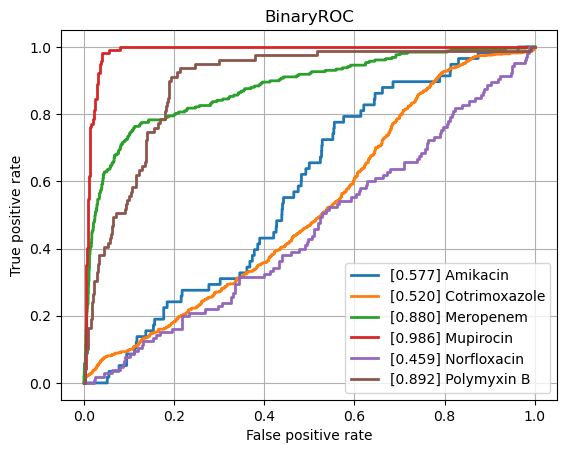

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics))
fig_, ax_ = ml_roc()

plt.show()

(0.48166967796928745, 0.6113468408584595)


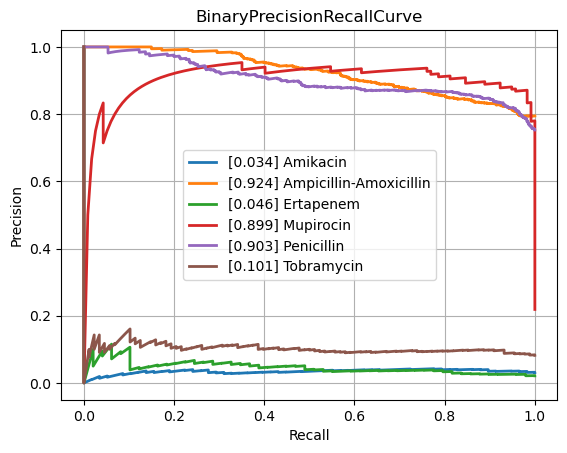

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./results.csv"))

fig_, ax_ = ml_pr()

plt.show()

In [ ]:
test_features.shape

torch.Size([5490, 18000])

In [ ]:
#test_features= test_features[1:,:]
#test_labels= test_labels[1:,:]

In [ ]:
split1,split2 = torch.chunk(test_features, 2)
combined =torch.add(split1 , split2)
combined_features = torch.div(combined, 2)

In [ ]:
split1,split2 = torch.chunk(test_labels, 2)
combined =torch.add(split1 , split2)
combined_labels = torch.div(combined, 2)
combined_labels[combined_labels == 0.5] =1

In [ ]:
latent, output = model(combined_features)

(0.7028185541138929, 0.7496914863586426)


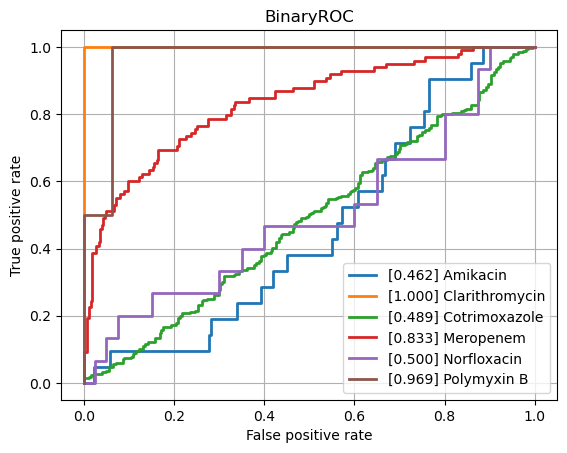

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,combined_labels,driams.selected_antibiotics))
fig_, ax_ = ml_roc()

plt.show()

(0.6096600601997446, 0.6575345993041992)


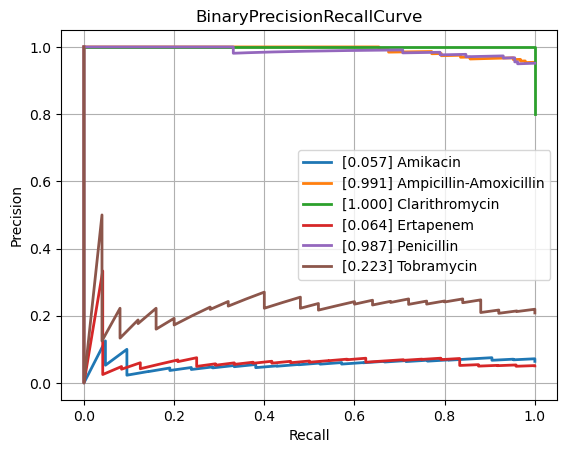

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./combined_results.csv"))

fig_, ax_ = ml_pr()

plt.show()

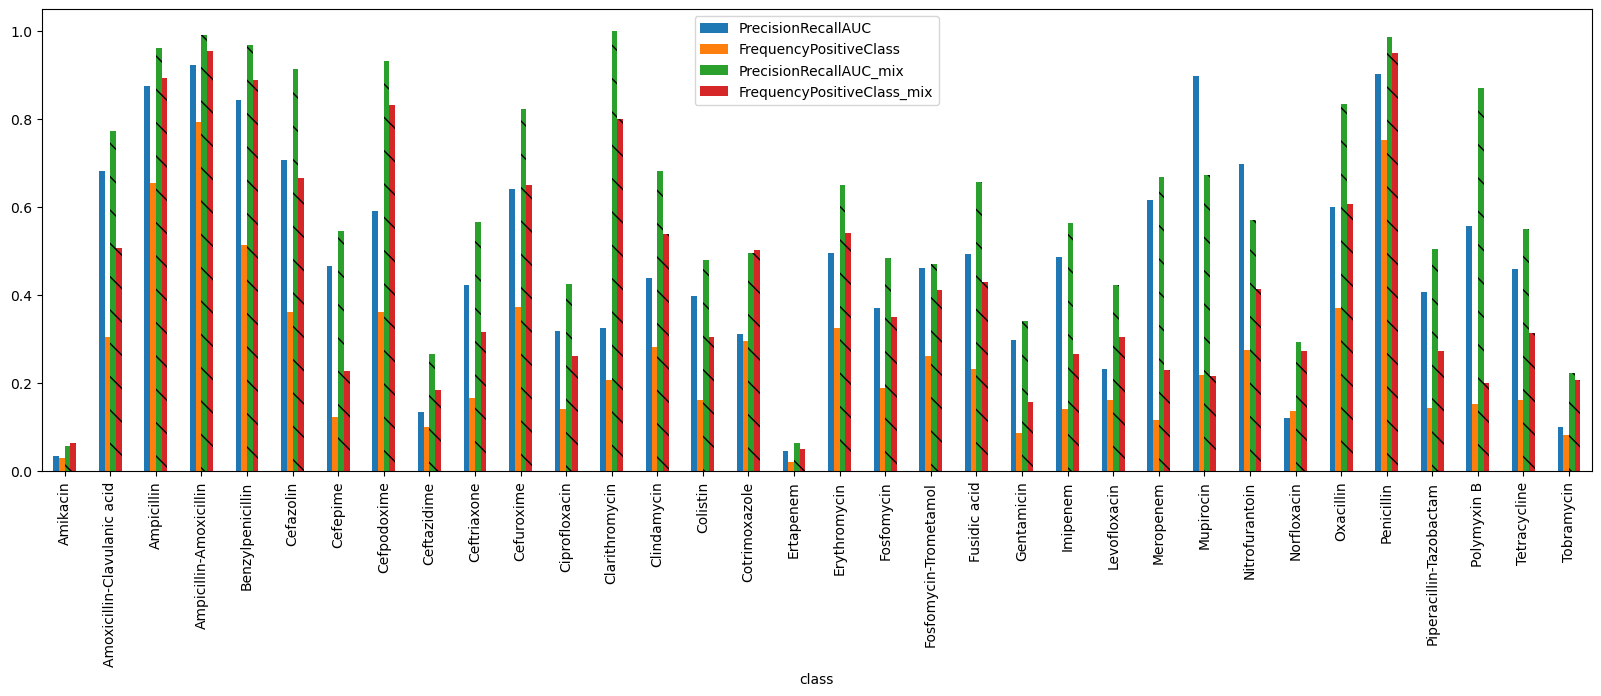

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.style.use("default")

result = pd.read_csv('./results.csv')
mix_result = pd.read_csv('./combined_results.csv')

combined = pd.merge(result, mix_result, on='class', how='outer', suffixes=('', '_mix'))
combined.set_index("class", inplace=True)

ax = combined.plot.bar(figsize=(20,6))
ax.set_facecolor("none")

for bar in ax.containers:
    if bar.get_label() in ["PrecisionRecallAUC_mix", "FrequencyPositiveClass_mix"]:
        plt.setp(bar, hatch= "\\")

path = Path("/home/jan/Uni/master/data/created_figures/ArtificialData/FeedForward/PrecisionRecall.png")
plt.savefig(path, transparent=True, format= "png", bbox_inches = "tight")
plt.show()